# Sparsification Kernel

## Theory

We propose an R-Convolution kernel based on community decomposition (and more generally graph sparsification).

We will show how given a unique graph decomposition robust to (some amount of) changes to the underlying graph we can construct an R-Convolution kernel. By representing the graph as a bag of parts from this unique decomposition we can take a divide-and-conquer approach to graph similarity. Considering each part individually allows for the parallelization of computation. As these parts are much smaller than the original graph, we can use kernels that would be intractable over the entire graph. Both of these should allow us to scale a graph kernel to larger graphs.

We'll consider community structure as such a unique graph decomposition. A community is a subset of the vertices that are densely connected internally and sparsely connected externally. Community structure can be represented as a partition of a graph's vertices. We claim a graph's communities are such a unique decomposition. Graphs with strong community structure should have a unique community decomposition. However this method will not be applicable to all families of graphs as for example the Erdos-Renyi random graph will not have any community structure. Many "natural" graphs have been shown to have community structure, in particular social / communication networks between people. Communities should be robust to changes in the underlying graph as strong (i.e. identifiable) community structure requires having significantly more edges within a community than between communities.

Let $G$ and $G'$ be graphs that have a unique, stable community structure. Let $communities(G)$ denote the communities of $G$ and let $C \in communities(G)$ be the vertex-induced subgraph of $G$ with vertices equal to one of $G$'s communities and edges internal to that community. Let $k_\$(G, G')$ be a graph kernel. In particular it could be one that is too expensive to run on the entire graph.

We then want to compare the communities of $G$ to those of $G'$ using $k_\$$. As we don't know how to align the communities of these two graphs we'll first must compare each community of $G$ to every one in $G'$. To fit into the R-Convolution framework, we take each $C \in communities(G)$ as its own decomposition of $G$. Our R-Convolution kernel is then

$k(G, G') = \sum_{C_i \in communities(G)} \sum_{C_j \in communities(G')} k_\$(C_i, C_j)$

Example: $G$ and $G'$ need not have the same number of communities. Suppose $G$ is the complete graph $K_n$ and $G'$ is the $n$-barbell graph i.e. the graph formed by connecting two copies of $K_n$ by a single edge. Then
$k(G', G') = \sum_{C_i \in \{K_n, K_n\}} \sum_{C_j \in \{K_n, K_n\}} k_\$(C_i, C_j) = 4k_\$(K_n, K_n)$
and
$k(G, G') = \sum_{C_i \in \{K_n\}} \sum_{C_j \in \{K_n, K_n\}} k_\$(C, C) = 4k_\$(K_n, K_n)$.

To reduce the number of kernel evaluations we need to perform we can pick an alignment of the communities i.e. some mapping from communities of one graph to the other. We'll pick an alignment that maximizes the sum of the pairwise kernels. This is an instance of the assignment problem for which the Kuhn-Munkres algorithm provides a polynomial time solution (see Label Swapping Problem [here](https://ruor.uottawa.ca/handle/10393/43171)).

What's been proposed is not a complete kernel as we are discarding the edges between communities and hence cannot distinguish between graphs that can be decomposed into the same set of subgraphs (and where our community detection method chooses this decomposition). Consider the graph formed by contracting each community to a single vertex. These graphs could then be compared with kernel $k_\$$. This would look for lower resolution similarity. This might be interesting on its own if only lower resolution similarity is of interest, or as an approximate similarity.

*TODO: How can we get closer to a complete kernel? How can the similarity of the contracted graphs contribute to the pairwise community similarities? Can we just do a brute force solving of the isomorphism problem on this contracted graph, with the community subgraphs as vertex labels? Do the isomorphisms of the contracted graph restrict the choices of permutations that maximize the sum of kernels evaluated on community pairs?*

This community R-Convolution kernel could be generalized to work with any graph sparsification method that produces stable and unique sparsifications. Most sparsification techniques try to preserve the spectrum, and since the spectrum is robust to small changes in the graph, these sparsification methods should be stable as well. Then the communities would just be the subgraphs that were contracted during sparsification.

## Dataset

We use the NCI1 dataset of chemical compounds that have been classified as carcinogenic or not.
It was downloaded from [TUDataset: A collection of benchmark datasets for learning with graphs](https://chrsmrrs.github.io/datasets/docs/datasets/).
There is a [leaderboard](https://paperswithcode.com/sota/graph-classification-on-nci1) evaluating graph embedding algorithms on this classification task.

## Experiments

In experiments we will take the community decomposition to be the partition with the optimal modularity. Note that finding this optimal partition is intractable for large graphs. If this approach shows promise then there are efficient algorithms for community detection that could be used instead, for example the multilevel Louvain algorithm. While these don't guarantee a unique decomposition, their compositions may be stable enough.

### Setup

To plot graphs the `cairo` 2D graphics library is required.
It can be installed on Linux by running
```shell
sudo apt install libcairo2-dev
```
Windows installation instructions can be found [here](https://doc.courtbouillon.org/cairocffi/stable/overview.html#installing-cairo-on-windows).

If using `pip` instead of `pipenv` for dependency management, uncomment and run the below cell.

In [1]:
# ! pip install --quiet igraph cairocffi

In [53]:
from collections import Counter
from dataclasses import dataclass
from pathlib import Path
import pickle

import grakel
from grakel.kernels import WeisfeilerLehman, VertexHistogram
import igraph
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import sklearn.linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression
from tqdm import tqdm

In [3]:
sns.set()

### Load graphs

The dataset file format is described [on the TUDataset site](https://chrsmrrs.github.io/datasets/docs/format/).

In [16]:
data = Path("data")
if not data.exists():
    raise FileNotFoundError("Path to data directory not set")

In [17]:
# Make 1-based vertex names 0-based.
edges = [tuple(map(lambda x: int(x) - 1, edge.split(",")))
         for edge in (data / "NCI1/NCI1_A.txt").read_text().split()]

In [18]:
graph = igraph.Graph.TupleList(edges, directed=False)

In [19]:
# Make 1-based subgraph names 0-based.
subgraph_labels = np.array([
    int(x) - 1 for x in (data / "NCI1/NCI1_graph_indicator.txt").read_text().split()
])

In [20]:
class_labels = np.array([
    int(x) for x in (data / "NCI1/NCI1_graph_labels.txt").read_text().split()
])

In [21]:
node_labels = np.array([
    int(x) for x in (data / "NCI1/NCI1_node_labels.txt").read_text().split()
])

In [22]:
for v in graph.vs:
    v["graph"] = subgraph_labels[v["name"]]
    v["label"] = node_labels[v["name"]]

### Properties of these graphs

In [12]:
print(f"Number of graphs: {max(subgraph_labels) + 1}")

Number of graphs: 4110


In [13]:
print(f"The classes are roughly balanced: {Counter(class_labels).most_common()}")

The classes are roughly balanced: [(1, 2057), (0, 2053)]


In [14]:
print((f"The {max(subgraph_labels) + 1} graphs have "
       f"{graph.vcount():,} vertices and {graph.ecount():,} edges "
       "in total so are sparse"))

The 4110 graphs have 122,319 vertices and 265,506 edges in total so are sparse


In [15]:
print(f"Number of node labels i.e. distinct atoms present: {len(Counter(node_labels))}")

Number of node labels i.e. distinct atoms present: 37


In [16]:
# Check whether each graph is connected.
connected = np.empty(shape=(max(subgraph_labels) + 1,), dtype=bool)
for i in tqdm(range(max(subgraph_labels) + 1)):
    g = graph.subgraph(np.where(np.array(graph.vs["graph"]) == i)[0].tolist())
    connected[i] = g.is_connected()

100%|██████████| 4110/4110 [00:19<00:00, 212.79it/s]


In [17]:
print((f"{connected.sum()}/{len(connected)} ~= "
       f"{np.round(connected.sum() / len(connected), 3)} "
       "of the graphs are connected"))

3865/4110 ~= 0.94 of the graphs are connected


In [23]:
%%time
vcounts = []
for i in tqdm(range(max(graph.vs["graph"])+1)):
    g = graph.subgraph(np.where(np.array(graph.vs["graph"]) == i)[0].tolist())
    vcounts.append(g.vcount())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4110/4110 [00:40<00:00, 101.45it/s]

CPU times: user 40.5 s, sys: 129 ms, total: 40.7 s
Wall time: 40.6 s


In [24]:
min(vcounts), max(vcounts)

(3, 111)

In [25]:
%%time
ecounts = []
for i in tqdm(range(max(graph.vs["graph"])+1)):
    g = graph.subgraph(np.where(np.array(graph.vs["graph"]) == i)[0].tolist())
    ecounts.append(g.ecount())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4110/4110 [00:39<00:00, 104.67it/s]

CPU times: user 39.2 s, sys: 165 ms, total: 39.4 s
Wall time: 39.3 s


In [26]:
min(ecounts), max(ecounts)

(4, 238)

### Compute clusterings i.e. community decomposition for each graph

Find communties for each graph using the optimal modularity.
Note this will be slow; there are speed ups such as multilevel Louvain that could be used instead.

In [11]:
# TODO: Use arrays instead of pickled igraph.clustering.VertexClustering .
if not Path(data / "clusterings.pkl").exists():
    # Find communities for each graph.
    clusterings = []
    for i in tqdm(range(max(G.vs["graph"])+1)):
        g = G.subgraph(np.where(np.array(G.vs["graph"]) == i)[0].tolist())
        clusterings.append(g.community_optimal_modularity())
    Path(data / "clusterings.pkl").write_bytes(pickle.dumps(clusterings))
else:
    clusterings = pickle.loads((data / "clusterings.pkl").read_bytes())

In [14]:
modularities = [clustering.modularity for clustering in clusterings]

In [ ]:
sns.kdeplot(data=modularities, clip=(0, max(df[6])), bw_adjust=2, fill=True, ax=ax)

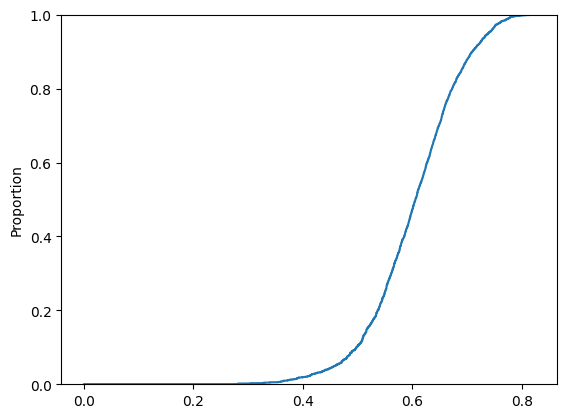

In [29]:
sns.ecdfplot(modularities)
plt.show()

### R-convolution kernel with communities as parts

In [31]:
# TODO: Finish implementation.
def community_kernel(g0: igraph.clustering.VertexClustering,
                     g1: igraph.clustering.VertexClustering) -> float:
    value = 0
    for c0 in range(max(g0.membership)):
        s0 = g0.subgraph(c0)
        for c1 in range(max(g1.membership)):
            s1 = g1.subgraph(c1)
            # https://ysig.github.io/GraKeL/0.1a8/documentation/introduction.html#computing-the-kernel-between-two-graphs
            kernel = GraphKernel(normalize=True, kernel="shortest_path")
            kernel.fit_transform([s0])
            kernel.transform([s1])
            value += kernel(s0, s1)
    return value

In [36]:
def bag_of_communities(g: igraph.clustering.VertexClustering
    ) -> list:
    # TODO: Finish implementation.
    raise NotImplementedError

#### Converting graphs to grakel

In [68]:
# TODO: Finish.
def igraph_to_grakel(g_igraph: igraph.Graph) -> grakel.graph.Graph:
    g_networkx = g_igraph.to_networkx(vertex_attr_hashable="name")
    labels = dict(zip(g_igraph.vs["name"], g_igraph.vs["label"]))
    networkx.set_node_attributes(g_networkx, labels, "label")
    return next(grakel.graph_from_networkx([g_igraph.to_networkx()]))
    # return next(grakel.graph_from_networkx([graph.to_networkx()], as_Graph=True))

In [100]:
# g_igraph = g0
g_networkx = g_igraph.to_networkx(create_using=networkx.Graph, vertex_attr_hashable="name")
# labels = dict(zip(g_igraph.vs["name"], g_igraph.vs["label"]))
# networkx.set_node_attributes(g_networkx, labels, "label")

In [ ]:
networkx.set_node_attributes(G2, {0:'a', 1:'b', 2:'c'}, 'label')

In [71]:
networkx.set_node_attributes

<function networkx.classes.function.set_node_attributes(G, values, name=None)>

In [44]:
next(grakel.graph_from_networkx([networkx.cycle_graph(6)]))

[{0: {1: 1.0, 5: 1.0},
  1: {0: 1.0, 2: 1.0},
  2: {1: 1.0, 3: 1.0},
  3: {2: 1.0, 4: 1.0},
  4: {3: 1.0, 5: 1.0},
  5: {4: 1.0, 0: 1.0}},
 None,
 None]

In [47]:
grakel.Graph({1: [2, 3], 2: [1], 3: [1]})

In [48]:
next(grakel.graph_from_networkx([igraph.Graph.Ring(6).to_networkx()]))

[{0: {1: 1.0, 5: 1.0},
  1: {0: 1.0, 2: 1.0},
  2: {1: 1.0, 3: 1.0},
  3: {2: 1.0, 4: 1.0},
  4: {3: 1.0, 5: 1.0},
  5: {4: 1.0, 0: 1.0}},
 None,
 None]

In [49]:
grakel.Graph(grakel.graph_from_networkx([igraph.Graph.Ring(6).to_networkx()]))

In [51]:
next(grakel.graph_from_networkx([igraph.Graph.Ring(6).to_networkx()], as_Graph=True))

In [65]:
x = next(grakel.graph_from_networkx([graph.to_networkx()], node_labels_tag="label"))

In [70]:
help(graph.to_networkx)

Help on method _export_graph_to_networkx in module igraph.io.libraries:

_export_graph_to_networkx(create_using=None, vertex_attr_hashable: str = '_nx_name') method of igraph.Graph instance
    Converts the graph to networkx format.
    
    igraph has ordered vertices and edges, but networkx does not. To keep
    track of the original order, the '_igraph_index' vertex property is
    added to both vertices and edges.
    
    @param create_using: specifies which NetworkX graph class to use when
        constructing the graph. C{None} means to let igraph infer the most
        appropriate class based on whether the graph is directed and whether
        it has multi-edges.
    @param vertex_attr_hashable: vertex attribute used to name vertices
        in the exported network. The default "_nx_name" ensures round trip
        conversions to/from networkx are lossless.



In [52]:
grakel.GraphKernel()

grakel.graph_kernels.GraphKernel

In [56]:
wl_kernel = WeisfeilerLehman(base_graph_kernel=VertexHistogram, normalize=True)

In [57]:
wl_kernel.fit_transform([])

WeisfeilerLehman(normalize=True)

In [60]:
g0 = graph.subgraph(np.where(np.array(graph.vs["graph"]) == 0)[0].tolist())

In [79]:
g_networkx = g0.to_networkx()
# TODO: Add labels.
# networkx.set_node_attributes(g_networkx, , "label")

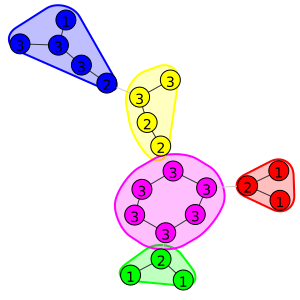

In [63]:
igraph.plot(clusterings[0], mark_groups=True, bbox=(300,300))

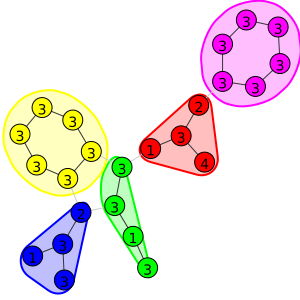

In [64]:
igraph.plot(clusterings[1], mark_groups=True, bbox=(300,300))

## Graph sparsification as a decomposition.

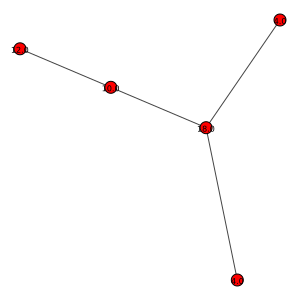

In [62]:
igraph.plot(clusterings[0].cluster_graph(combine_vertices="sum", combine_edges="sum"), bbox=(300,300), vertex_size=12, vertex_label_size=8)

In [34]:
help(graph.contract_vertices)

Help on built-in function contract_vertices:

contract_vertices(mapping, combine_attrs=None) method of igraph.Graph instance
    Contracts some vertices in the graph, i.e. replaces groups of vertices
    with single vertices. Edges are not affected.
    
    @param mapping: numeric vector which gives the mapping between old and
      new vertex IDs. Vertices having the same new vertex ID in this vector
      will be remapped into a single new vertex. It is safe to pass the
      membership vector of a L{VertexClustering} object here.
    @param combine_attrs: specifies how to combine the attributes of
      the vertices being collapsed into a single one. If it is C{None},
      all the attributes will be lost. If it is a function, the
      attributes of the vertices will be collected and passed on to
      that function which will return the new attribute value that has to
      be assigned to the single collapsed vertex. It can also be one of
      the following string constants whic

In [35]:
help(graph.simplify)

Help on built-in function simplify:

simplify(multiple=True, loops=True, combine_edges=None) method of igraph.Graph instance
    Simplifies a graph by removing self-loops and/or multiple edges.
    
    
    For example, suppose you have a graph with an edge attribute named
    C{weight}. C{graph.simplify(combine_edges=max)} will take the
    maximum of the weights of multiple edges and assign that weight to
    the collapsed edge. C{graph.simplify(combine_edges=sum)} will
    take the sum of the weights. You can also write
    C{graph.simplify(combine_edges=dict(weight="sum"))} or
    C{graph.simplify(combine_edges=dict(weight=sum))}, since
    C{sum} is recognised both as a Python built-in function and as
    a string constant.
    
    @param multiple: whether to remove multiple edges.
    @param loops: whether to remove loops.
    @param combine_edges: specifies how to combine the attributes of
      multiple edges between the same pair of vertices into a single
      attribute. If